In [1]:
### import os
import json

import logging
import datetime

import chess
import chess.polyglot
import chess.pgn

import numpy as np
import torch
import pandas as pd

from utils import dict_pieces, string_to_array
from train_functions import data_preparation, load_running_loss_evol, validation

## Games to tensor

In [2]:
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
np.random.seed(2)
seed = 2

In [3]:
gamma = 0.99

tensor_games = []
tensor_y = []

for d in range(40,80):
    with open("./data/games_dict/games_dict_{}.json".format(d), "r") as fp:
                dict_games = json.load(fp)

    for i in range(len(dict_games)):
        
        if dict_games[str(i)]["result"] == "W":
            alpha = 1
        elif dict_games[str(i)]["result"] == "B":
            alpha = -1
        elif dict_games[str(i)]["result"] == "D":
            alpha = 0
            
        if alpha!=0:
            for j in range(len(dict_games[str(i)]["moves"])):
                tensor_games += [np.concatenate((string_to_array(dict_games[str(i)]["moves"][str(j)]),
                                                 string_to_array(dict_games[str(i)]["moves"][str(j)], is_white=False)))]
            
            tensor_y += list(np.flip(np.power((np.ones(shape=len(dict_games[str(i)]["moves"]))*gamma),
                                            np.arange(len(dict_games[str(i)]["moves"]))))*alpha)
    
tensor_games = np.array(tensor_games)
tensor_y = np.array(tensor_y)
np.random.shuffle(tensor_games)
np.random.shuffle(tensor_y)

tensor_games = torch.from_numpy(tensor_games).type(torch.FloatTensor)
tensor_y = torch.from_numpy(tensor_y).type(torch.FloatTensor)

In [4]:
tensor_games.shape, tensor_y.shape

(torch.Size([1974630, 12, 8, 8]), torch.Size([1974630]))

In [5]:
tensor_games = tensor_games.to(device)
tensor_y = tensor_y.to(device)

In [6]:
frac_train_test = 0.9
batch_size = 64

X_train, X_test, y_train, y_test, trainloader, testloader = data_preparation(tensor_games, tensor_y, frac_train_test, batch_size, seed)

<AxesSubplot:>

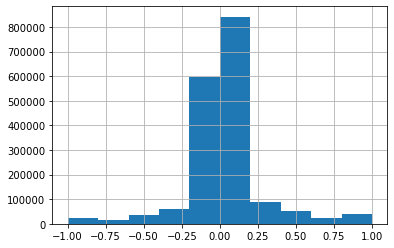

In [7]:
pd.Series(y_train.cpu().numpy()).hist()

<AxesSubplot:>

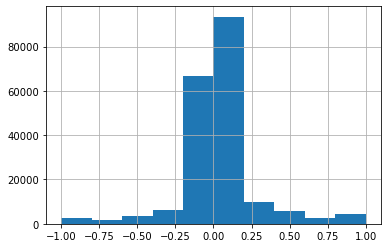

In [8]:
pd.Series(y_test.cpu().numpy()).hist()

## CNN

In [9]:
class CNN(torch.nn.Module):   
    def __init__(self, channels, n_strides, kernel):
        super(CNN, self).__init__()
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=12,
                            out_channels=256,
                            kernel_size=3,
                            stride=1,
                            padding=3),
            torch.nn.Dropout(p=0.2),
            torch.nn.BatchNorm2d(256),
            #torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(in_channels=256,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.Dropout(p=0.2),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=16,
                            kernel_size=3,
                            stride=1,
                            padding="same"),
            torch.nn.BatchNorm2d(16),
            #torch.nn.Tanh(),
        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features = 16*2*2,
                            out_features=1),
            torch.nn.Tanh(),
        )

    # Defining the forward pass    
    def forward(self, input_tensor):
        out_cnn = self.cnn_layers(input_tensor)
        out_linear = self.linear_layers(out_cnn.view(out_cnn.size(0), -1))
        return out_linear

In [10]:
model_name = "base7"
path_folder = "./training/{}".format(model_name)

logger = logging.getLogger("training_logger")
logger.setLevel(logging.INFO)
logging.basicConfig(filename=path_folder + "/train_logs.log", level=logging.INFO)

resume_training_at_epoch=0
epochs = 300
eta = (10**-3)
w_d = 0  # défaut = 0


model = CNN(channels=[512,128], n_strides=[1,1], kernel=[5,3]).to(device)
if resume_training_at_epoch>0:
    checkpoint = torch.load(path_folder + "/model_at_epoch_{}.pt".format(resume_training_at_epoch), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=w_d)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("model loaded")
else:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=w_d)

In [11]:
model.cnn_layers[0](testloader.dataset[:2][0]).shape

torch.Size([2, 256, 12, 12])

In [12]:
model.cnn_layers(testloader.dataset[:2][0]).shape

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 16, 2, 2])

In [13]:
model(testloader.dataset[:2][0])

tensor([[-0.5251],
        [-0.0409]], grad_fn=<TanhBackward>)

In [14]:
def loss_fn(outputs, targets):
    return torch.nn.MSELoss()(outputs, targets)

In [15]:
def training(n_epochs, resume_at_epoch=0, verbose_iteration=1000, checkpoint_epochs=5):
    
    running_loss_evol = load_running_loss_evol(path_folder, resume_at_epoch)
    running_loss_evol.to_csv(path_folder + "/loss_evol.csv")
    
    logger = logging.getLogger("training_logger")
    start_training = datetime.datetime.now()
    logger.info("                         /// Start training model from epoch={} to epoch={} ///                         ".format(resume_at_epoch, n_epochs-1))
    logger.info("                                       {}                                       ".format(start_training))
    
    for epoch in np.arange(resume_at_epoch, n_epochs, 1):
        start_epoch = datetime.datetime.now()
        logger.info("---------------------------------------------- Epoch #{} ----------------------------------------------".format(epoch))
        logger.info("                                       {}                                       ".format(start_epoch))
        running_loss = 0.0
        model.train()
        
        start_batchs = datetime.datetime.now()
        for i, batch in enumerate(trainloader, 0):
                
            input_boards = batch[0].to(device)
            labels = batch[1].to(device)

            optimizer.zero_grad()
            outputs = model(input_boards)

            loss = loss_fn(torch.reshape(outputs, (-1,)), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # print statistics
            if int(i+1) % verbose_iteration == 0:
                batchs_duration = (datetime.datetime.now() - start_batchs).seconds
                logger.info("----> Batch #{}, loss={:.6f}, duration={} seconds".format(i+1, running_loss / verbose_iteration, batchs_duration))
                running_loss_evol.loc[len(running_loss_evol),"epoch"] = epoch
                running_loss_evol.loc[len(running_loss_evol)-1,"batch"] = i+1
                running_loss_evol.loc[len(running_loss_evol)-1,"mean loss"] = running_loss / verbose_iteration
                running_loss_evol.loc[len(running_loss_evol)-1,"learning rate"] = eta
                running_loss_evol.loc[len(running_loss_evol)-1,"duration"] = batchs_duration
                running_loss = 0.0  
                running_loss_evol.to_csv(path_folder + "/loss_evol.csv")
                start_batchs = datetime.datetime.now()

        # save validation results
        dict_distribs, dict_stats = validation(model, testloader, device)
        dict_distribs, dict_stats = dict_distribs.fillna(0).to_dict(), dict_stats.fillna(0).to_dict()
        
        epoch_duration = (datetime.datetime.now() - start_epoch).seconds
        
        with open(path_folder + "/validation_results.json") as fp:
            val_results = json.load(fp)
            val_results["epoch {}".format(epoch)] = {"duration": epoch_duration,
                                                     "results_distrib": dict_distribs,
                                                     "results_stats" : dict_stats}
        with open(path_folder + "/validation_results.json", 'w') as fp:
            json.dump(val_results, fp, indent=4)

            
        if int(epoch+1) % checkpoint_epochs == 0:
            # save model & optimizer
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss},path_folder + "/model_at_epoch_{}.pt".format(epoch+1))
        
    logger.info("                                       {}                                       ".format(datetime.datetime.now()))
    logger.info("                           /// End training model from epoch={} to epoch={} ///                           ".format(resume_at_epoch, n_epochs-1))

In [16]:
model.to(device)

training(n_epochs=500, resume_at_epoch=resume_training_at_epoch, verbose_iteration=5000, checkpoint_epochs=5)

KeyboardInterrupt: 